In [16]:
import utils
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

import dpctl
print(dpctl.get_devices())
from sklearnex import patch_sklearn, config_context
patch_sklearn()
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
device = 'cpu'
DIR_PATH = "Data"
DIRPATH_EXTRACTED_FEATURES = "extracted_features"

[]
cuda


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [17]:
class CustomDataset():
    def __init__(self, brands: list, filenames_features: list, filename_target=utils.FILENAME_RELEVANCE_WINDOW, log_target=False, device=device, percentile=100):
        self.log_target = log_target
        tensor = torch.concat([torch.concat([torch.load(os.path.join(DIRPATH_EXTRACTED_FEATURES, brand, filename_feature), map_location=device, weights_only=False) 
                                for filename_feature in filenames_features], dim=1)
                                  for brand in brands], dim=0)
        numpy_array = tensor.detach().numpy()
        features = pd.DataFrame(numpy_array)

        tensor = torch.concat([torch.load(os.path.join(DIRPATH_EXTRACTED_FEATURES, brand, filename_target), map_location=device, weights_only=False) 
                                  for brand in brands], dim=0)
        numpy_array = tensor.detach().numpy()
        self.target = pd.DataFrame(numpy_array)
        self.target.rename(columns={0:'target'}, inplace=True)
        if log_target:
              self.target = np.log(self.target)

        self.features_train, self.features_test, self.target_train, self.target_test = train_test_split(features, self.target, test_size = 0.1)
    
    def __len__(self):
        return len(self.target)
    
# class CustomDataset():
#     def __init__(self, brands: list, filenames_features: list, filename_target=utils.FILENAME_RELEVANCE_WINDOW, log_target=False, device=device, percentile=100):
#         self.log_target = log_target
#         tensor = torch.concat([torch.concat([torch.load(os.path.join(DIRPATH_EXTRACTED_FEATURES, brand, filename_feature), map_location=device, weights_only=False) 
#                                 for filename_feature in filenames_features], dim=1)
#                                   for brand in brands], dim=0)
#         numpy_array = tensor.cpu().detach().numpy()
#         features = pd.DataFrame(numpy_array)

#         tensor = torch.concat([torch.load(os.path.join(DIRPATH_EXTRACTED_FEATURES, brand, filename_target), map_location=device, weights_only=False) 
#                                   for brand in brands], dim=0)
#         numpy_array = tensor.cpu().detach().numpy()
#         target = pd.DataFrame(numpy_array)
#         target.rename(columns={0:'target'}, inplace=True)
#         df = pd.concat([features, target], axis=1)
#         target_counts = df['target'].value_counts()

#         threshold = np.percentile(target_counts.values, percentile)
#         to_downsample = target_counts[target_counts > threshold].index

#         balanced_data = []
#         for value in target_counts.index:
#             subset = df[df['target'] == value]
#             if value in to_downsample:
#                 subset = subset.sample(int(threshold))
#             balanced_data.append(subset)

#         balanced_df = pd.concat(balanced_data)

#         self.features = balanced_df.drop(columns=['target'])
#         self.target = balanced_df.filter(['target'])
#         if log_target:
#               self.target = np.log(self.target)

#         self.features_train, self.features_test, self.target_train, self.target_test = train_test_split(self.features, self.target, test_size = 0.1, random_state=0)
    
#     def __len__(self):
#         return len(self.target)


class CustomRegressor():
    def __init__(self, range=None, percentile=100):
        if range: # gave errors when range was zero
            if range[0] == 0:
                range[0] += 1
        self.range = range
        self.percentile = percentile
        regressor = RandomForestRegressor(
            n_estimators=50,
            criterion='squared_error',
            min_samples_leaf=50,
            # max_features=.8,
            max_depth=None,
            oob_score=True,
            random_state=0,
            n_jobs=-1,
            )
        self.regressor = AdaBoostRegressor(
            estimator=regressor,
            n_estimators=50,
            learning_rate=1,
            loss='square',
            random_state=0,
            )
        # self.regressor = GradientBoostingRegressor( # testing required
        #     loss='squared_error',
        #     learning_rate=0.1,
        #     n_estimators=100,
        #     subsample=.7,
        #     criterion='squared_error',
        #     min_samples_leaf=50, # new test req, prev overfitting
        #     max_depth=None, # maybe upp this??
        #     random_state=0, 
        # )
        
    def fit(self, Data: CustomDataset):
        target_train = Data.target_train.rename(columns={0:'target'})
        target_range = (target_train['target'].min(), target_train['target'].max() + 1)
        if self.range:
            target_range = self.range
            if Data.log_target:
                target_range = np.log(target_range)
        df = pd.concat([Data.features_train, target_train], axis=1)
        df = df[df['target'] >= target_range[0]]
        df = df[df['target'] < target_range[1]]
        
        target_counts = df['target'].value_counts()

        threshold = np.percentile(target_counts.values, self.percentile)
        to_downsample = target_counts[target_counts > threshold].index

        balanced_data = []
        for value in target_counts.index:
            subset = df[df['target'] == value]
            if value in to_downsample:
                subset = subset.sample(int(threshold))
            balanced_data.append(subset)

        balanced_df = pd.concat(balanced_data)
        
        features_train = balanced_df.drop(columns=['target'])
        target_train = balanced_df['target']
        
        self.regressor.fit(features_train, target_train)

    def oob_score(self):
        print(f'Out-of-Bag Score: {self.regressor.oob_score_}')
        
    def score(self, Data: CustomDataset):
        target_test = Data.target_test.rename(columns={0:'target'})
        target_range = (target_test['target'].min(), target_test['target'].max() + 1)
        if self.range:
            if Data.log_target:
                target_range = np.log(self.range)

        df = pd.concat([Data.features_test, target_test], axis=1)
        df = df[df['target'] >= target_range[0]]
        df = df[df['target'] < target_range[1]]
        features_test = df.drop(columns=['target'])
        target_test = df['target']

        predictions = self.regressor.predict(features_test)
        # self.oob_score()
        mse = mean_squared_error(target_test, predictions)
        r2 = r2_score(target_test, predictions)
        print(f'Mean Squared Error: {mse}')
        print(f'R-squared: {r2}')

    def predict_train(self, Data: CustomDataset):
        return self.regressor.predict(Data.features_train)

    def predict_test(self, Data: CustomDataset):
        return self.regressor.predict(Data.features_test)
    
    def predict(self, Data):
        return self.regressor.predict(Data)
        

class CustomClassifier():
    def __init__(self, bins):
        self.bins = bins
        self.classifier = RandomForestClassifier(
            n_estimators=200,
            criterion='gini',
            max_depth=None,
            min_samples_leaf=20,
            oob_score=True,
            random_state=0,
        )
        
    def fit(self, Data: CustomDataset):
        if Data.log_target:
            train_bins = (Data.target_train).map(np.exp)
        else:
            train_bins = Data.target_train
        train_bins = pd.cut(train_bins[0], bins=self.bins, labels=[i for i in range(len(self.bins) - 1)])
        self.classifier.fit(Data.features_train, train_bins)

    def oob_score(self):
        print(f'Out-of-Bag Score: {self.classifier.oob_score_}')
        
    def score(self, Data: CustomDataset):
        if Data.log_target:
            train_bins = (Data.target_train).map(np.exp)
            test_bins = (Data.target_test).map(np.exp)
        else:
            train_bins = Data.target_train
            test_bins = Data.target_test
        train_bins = pd.cut(train_bins[0], bins=self.bins, labels=[i for i in range(len(self.bins) - 1)])
        test_bins = pd.cut(test_bins[0], bins=self.bins, labels=[i for i in range(len(self.bins) - 1)])

        target_train_pred = self.classifier.predict(Data.features_train)
        target_test_pred = self.classifier.predict(Data.features_test)
        train_accuracy = accuracy_score(train_bins, target_train_pred)
        test_accuracy = accuracy_score(test_bins, target_test_pred)

        self.oob_score()
        print("Train Accuracy: %.1f%%" %(train_accuracy * 100))
        print("Test Accuracy: %.1f%%" %(test_accuracy * 100))

    def predict_train(self, Data: CustomDataset):
        return self.classifier.predict(Data.features_train)

    def predict_test(self, Data: CustomDataset):
        print(Data.target_test)
        return self.classifier.predict(Data.features_test)
    
    def predict(self, Data):
        return self.classifier.predict(Data)

In [18]:
filenames_features = [
    utils.FILENAME_BRAND_OHE,
    utils.FILENAME_PUBLICATION_TIMESTAMP,
    utils.FILENAME_PUBLICATION_WEEKDAY_OHE,
    utils.FILENAME_NUM_WORDS,
    utils.FILENAME_NUM_PARAGRAPH,
    # utils.FILENAME_MAIN_SECTION_OHE,
    # utils.FILENAME_MAIN_SECTION_EMB,
    # utils.FILENAME_SUBSECTIONS_OHE,
    # utils.FILENAME_SUBSECTIONS_EMB,
    utils.FILENAME_MAIN_SECTION_SUBSECTIONS_MEAN_EMB,
    utils.FILENAME_USER_NEEDS,
    utils.FILENAME_LDA_TOPICS,
    utils.FILENAME_IPTC_TOPICS_LEVEL_0,
    utils.FILENAME_IPTC_TOPICS_LEVEL_1,
]

brands = utils.ALL_BRANDS
# brands = ['ad']
# brands = ['brabantsdagblad']
# brands = ['destentor']
# brands = ['nu']
# brands = ['parool']
# brands = ['trouw']
# brands = ['volkskrant']
# brands = ['ad', 'brabantsdagblad', 'destentor']
# brands = ['parool', 'trouw', 'volkskrant']

bins = [0, 30, 60, 100, 1000]

In [19]:
Data = CustomDataset(brands, filenames_features, log_target=True)
Data.features_train.shape

(192119, 473)

In [20]:
log_twentyfour = np.log(24)
if Data.log_target:
    target_pred = [log_twentyfour for _ in range(len(Data.target_test))]
else:
    target_pred = [24 for _ in range(len(Data.target_test))]

# print(mean_absolute_error(Data.target_test, target_pred))
print(mean_squared_error(Data.target_test, target_pred))
print(r2_score(Data.target_test, target_pred))

0.6863582685762059
-0.05679654145379609


In [21]:
%%script false --no-raise-error # to skip cell, analysing data

df = Data.target
target_counts = df[0].value_counts()

threshold = np.percentile(target_counts.values, 99.5)
to_downsample = target_counts[target_counts > threshold].index

balanced_data = []
for value in target_counts.index:
    subset = df[df[0] == value]
    if value in to_downsample:
        subset = subset.sample(int(threshold))
    balanced_data.append(subset)

# Combine back into a single dataframe
balanced_df = pd.concat(balanced_data)
balanced_df


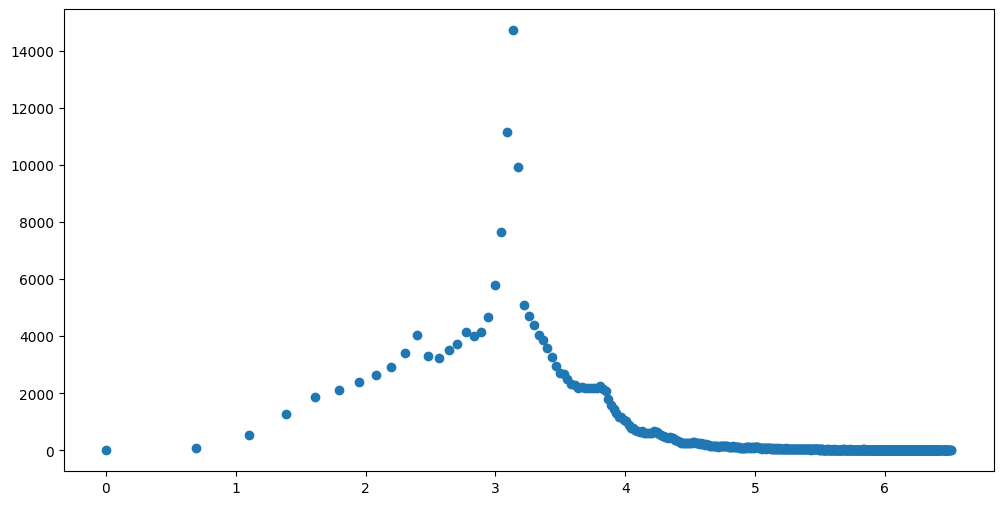

In [22]:
ground_truth_orderd = Data.target['target'].value_counts().sort_index()
# his_bins = np.histogram(ground_truth_orderd, bins=len(ground_truth_orderd.unque()))
ground_truth_orderd = ground_truth_orderd.loc[:100]
plt.figure(figsize=(12, 6))
plt.scatter(ground_truth_orderd.index,ground_truth_orderd.values)  # Adjust bins for readability
plt.show()

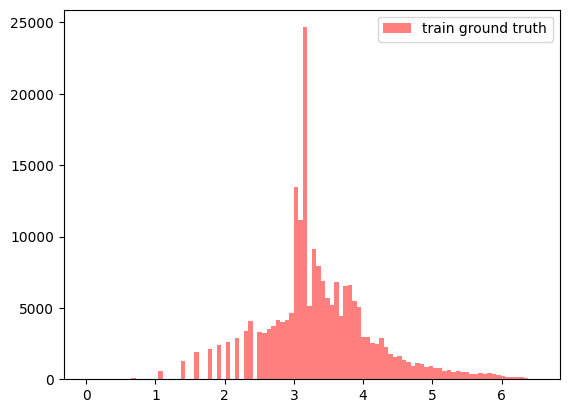

In [23]:
# %%script false --no-raise-error # to skip cell, analysing data

n_bins = 100
ground_truth = Data.target.mask(Data.target > 100).dropna()
his_bins = np.histogram(ground_truth, bins=n_bins)[1]

plt.hist(ground_truth, bins=his_bins, alpha=0.5, color='r', label='train ground truth')
plt.legend()
plt.show()

In [24]:
# %%script false --no-raise-error # to skip cell, simple forests 

regressor = CustomRegressor(percentile=99)
regressor.fit(Data)
print('regressor:')
regressor.score(Data)

# classifier = CustomClassifier(bins=bins)
# classifier.fit(Data)
# print('classifier:')
# classifier.score(Data)

regressor:
Mean Squared Error: 0.3977491855621338
R-squared: 0.3875793218612671


In [25]:
# %%script false --no-raise-error # to skip cell, simple forests 

y_train = pd.DataFrame(Data.target_train).rename(columns={'target':0})
y_pred_train = pd.DataFrame(regressor.predict_train(Data))
abs_dif_train = (y_pred_train - y_train).map(np.abs)

y_test = pd.DataFrame(Data.target_test).rename(columns={'target':0})
y_pred_test = pd.DataFrame(regressor.predict_test(Data))
abs_dif_test = (y_pred_test - y_test).map(np.abs)

print('mse train:\n', mean_squared_error(y_train, y_pred_train))
print('r2 train:\n', r2_score(y_train, y_pred_train))
print('mse train:\n', mean_squared_error(y_test, y_pred_test))
print('r2 train:\n', r2_score(y_test, y_pred_test))

mse train:
 0.18914170790557155
r2 train:
 0.7010578821778825
mse train:
 0.39774917442653146
r2 train:
 0.3875793865323105


In [26]:
%%script false --no-raise-error # to skip cell, simple forests 
import torch.nn as nn
metric = nn.MSELoss(reduction='none')

y_train = pd.DataFrame(Data_full.target_train).rename(columns={'target':0})
y_pred_train = pd.DataFrame(regressor.predict_train(Data_full))
abs_dif_train = metric(y_pred_train, y_train)

y_test = pd.DataFrame(Data_full.target_test).rename(columns={'target':0})
y_pred_test = pd.DataFrame(regressor.predict_test(Data_full))
abs_dif_test = metric(y_pred_test, y_test)

In [27]:
%%script false --no-raise-error # to skip cell, custom forests 

regressors = []
for n, lower in enumerate(bins[:-1]):
    regressors.append(CustomRegressor([lower, bins[n + 1]]))

regressors = [] # testing something
for i in range(len(bins) - 1):
    if i == 0:
        lower = bins[i]
    else:
        lower = bins[i - 1]
    if i == len(bins) - 2:
        higher = bins[i + 1]
    else:
        higher = bins[i + 2]
    regressors.append(CustomRegressor([lower, higher]))

classifier = CustomClassifier(bins)

for regressor in regressors:
    regressor.fit(Data)
    print(f'Regressor {regressor.range} trained')

classifier.fit(Data)
print('Classifier trained')

def class_regression(features):
    bin_predictions = classifier.predict(features)

    final_predictions = []
    for i, bin_idx in enumerate(bin_predictions):
        final_predictions.append(regressors[bin_idx].predict(features.iloc[[i]])[0])

    return pd.DataFrame(final_predictions, columns=[0])

final_predictions_test = class_regression(Data.features_test)
print("Final test predictions made")

final_predictions_train = class_regression(Data.features_train)
print("Final train predictions made")

y_train = pd.DataFrame(Data.target_train)
y_pred_train = final_predictions_train
abs_dif_train = (y_pred_train - y_train).map(np.abs)

y_test = pd.DataFrame(Data.target_test)
y_pred_test = final_predictions_test
abs_dif_test = (y_pred_test - y_test).map(np.abs)

In [28]:
%%script false --no-raise-error # to skip cell, simple forests 

print('m_absolute_error: ',mean_absolute_error(Data.target_test, final_predictions_test))
print('m_squared_error: ',mean_squared_error(Data.target_test, final_predictions_test))
print('m_squared_error_exped: ',mean_squared_error((Data.target_test).map(np.exp), (final_predictions_test).map(np.exp)))
print('r2_score: ',r2_score(Data.target_test, final_predictions_test))

print('classifier:')
classifier.score(Data)

for regressor in regressors:
    print(f'regressor {regressor.range}:')
    regressor.score(Data)

train 
 diff mean: 0.7330656975583587, diff std: 0.6107963335612949
test 
 diff mean: 0.5906383300014098, diff std: 0.5037388457356194


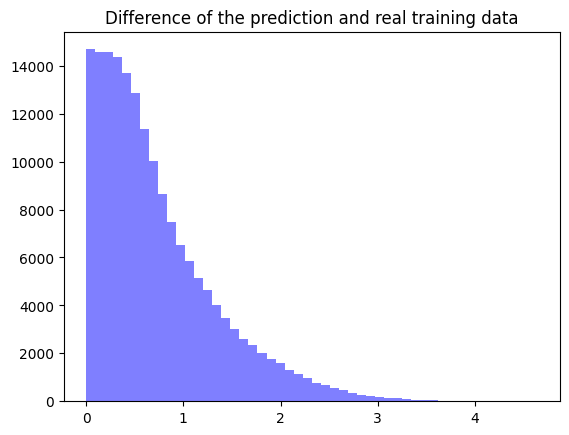

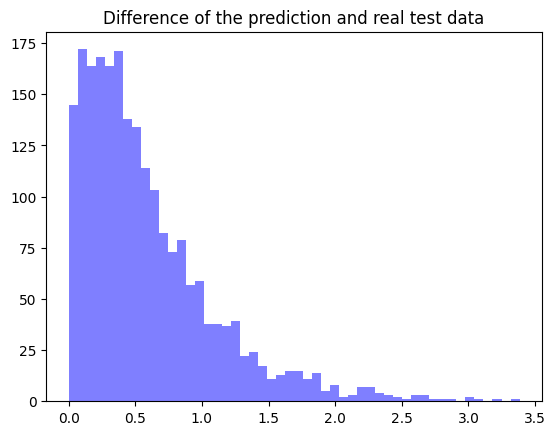

In [29]:
print(f'train \n diff mean: {abs_dif_train.mean()[0]}, diff std: {abs_dif_train.std()[0]}')
print(f'test \n diff mean: {abs_dif_test.mean()[0]}, diff std: {abs_dif_test.std()[0]}')
plt.hist(abs_dif_train, bins=50, alpha=0.5, color='b')
plt.title('Difference of the prediction and real training data')
plt.show()
plt.hist(abs_dif_test, bins=50, alpha=0.5, color='b')
plt.title('Difference of the prediction and real test data')
plt.show()

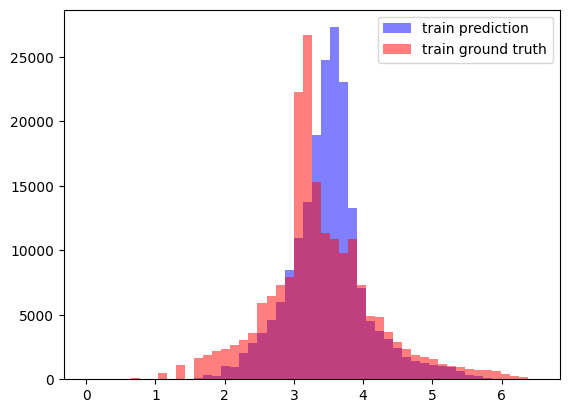

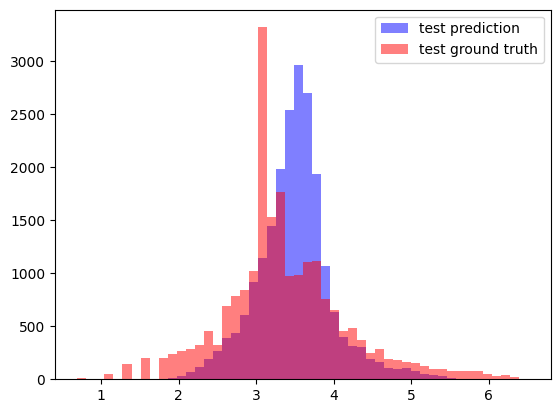

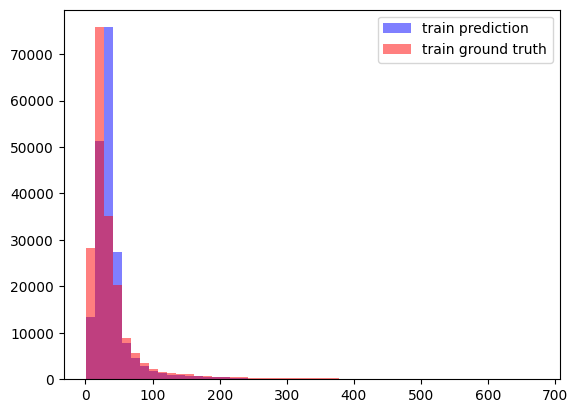

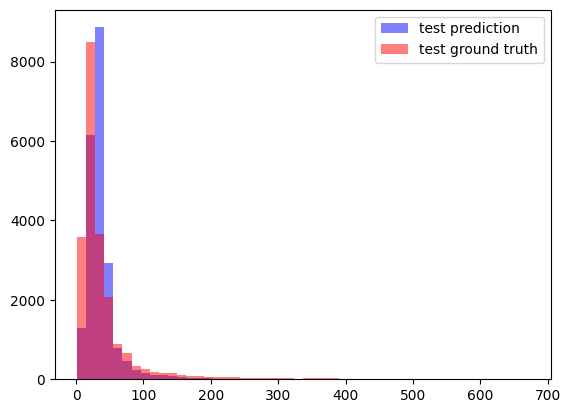

In [30]:
n_bins = 50
bins = np.histogram(np.hstack((y_pred_train,y_train)), bins=n_bins)[1]
plt.hist(y_pred_train, bins=bins, alpha=0.5, color='b', label='train prediction')
plt.hist(y_train, bins=bins, alpha=0.5, color='r', label='train ground truth')
plt.legend()
plt.show()

bins = np.histogram(np.hstack((y_pred_test,y_test)), bins=n_bins)[1]
plt.hist(y_pred_test, bins=bins, alpha=0.5, color='b', label='test prediction')
plt.hist(y_test, bins=bins, alpha=0.5, color='r', label='test ground truth')
plt.legend()
plt.show()

if Data.log_target:
    y_pred_train_trans = (y_pred_train).map(np.exp)
    y_train_trans = (y_train).map(np.exp)
    y_pred_test_trans = (y_pred_test).map(np.exp)
    y_test_trans = (y_test).map(np.exp)
else:
    y_pred_train_trans = (y_pred_train).map(np.log)
    y_train_trans = (y_train).map(np.log)
    y_pred_test_trans = (y_pred_test).map(np.log)
    y_test_trans = (y_test).map(np.log)

bins = np.histogram(np.hstack((y_pred_train_trans,y_train_trans)), bins=n_bins)[1]
plt.hist(y_pred_train_trans, bins=bins, alpha=0.5, color='b', label='train prediction')
plt.hist(y_train_trans, bins=bins, alpha=0.5, color='r', label='train ground truth')
# plt.xlim(xmin=1, xmax = 200)
plt.legend()
plt.show()

bins = np.histogram(np.hstack((y_pred_test_trans,y_test_trans)), bins=n_bins)[1]
plt.hist(y_pred_test_trans, bins=bins, alpha=0.5, color='b', label='test prediction')
plt.hist(y_test_trans, bins=bins, alpha=0.5, color='r', label='test ground truth')
plt.legend()
plt.show()